<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


In [6]:
data['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Пропусков и дубликатов нет, присутствует сильный дисбаланс классов, в тексте присутствуют ненужные символы.

Приступим к обработке.

In [7]:
# Функция оставляет в тексте только буквы
def regex_cleaning(row):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', row).split())

data['text'] = data['text'].apply(regex_cleaning)

Проведем лемматизацию текста с использованием POS-тегов для WordNet

In [8]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

In [9]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(row):
    return " ".join([lemmatizer.lemmatize(sent, get_wordnet_pos(sent)) for sent in nltk.word_tokenize(row)])

Лемматизация занимает где-то 20 минут, потому загружаю заранее обработанный текст с репозитория, чтобы не тратить время снова при запуске.

In [10]:
#data['lemm_text'] = data['text'].apply(lemmatize)
url = 'https://github.com/IvanTau/Praktikum/blob/main/%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D1%82%D0%BE%D0%BA%D1%81%D0%B8%D1%87%D0%BD%D1%8B%D1%85%20%D0%BA%D0%BE%D0%BC%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%B8%D0%B5%D0%B2/toxic_data_lemm.csv?raw=true'
data['lemm_text'] = pd.read_csv(url)

In [11]:
data.head()

,text,toxic,lemm_text
0,Explanation Why the edits made under my userna...,0,Explanation Why the edits make under my userna...
1,D aww He matches this background colour I m se...,0,D aww He match this background colour I m seem...
2,Hey man I m really not trying to edit war It s...,0,Hey man I m really not try to edit war It s ju...
3,More I can t make any real suggestions on impr...,0,More I can t make any real suggestion on impro...
4,You sir are my hero Any chance you remember wh...,0,You sir be my hero Any chance you remember wha...


Выделим выборки для обучения.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['lemm_text'], 
                                                    data['toxic'], 
                                                    stratify=data['toxic'], 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')

Проведем векторизацию текста, удалив стоп-слова.

In [13]:
stopwords = set(nltk_stopwords.words('english'))
counter = TfidfVectorizer(stop_words=stopwords)
counter.fit(X_train)
tfidf_train = counter.transform(X_train)
tfidf_test = counter.transform(X_test)

## Обучение и тестирование

Подбор гиперпараметров моделей был сделан ранее через GridSeachCV, этот процесс занимает много времени на таком большом датасете, потому ниже представлено обучение и тестирование моделей уже с лучшими параметрами.

In [14]:
def grid_train_test(model, params):
    """Подбор гиперпараметров"""
    skf = StratifiedKFold(3, random_state=42, shuffle=True)
    grid = GridSearchCV(model, params, n_jobs=-1, cv=skf, scoring='f1')
    grid.fit(tfidf_train, y_train)
    preds = grid.predict(tfidf_test)

    print('Параметры лучшей модели:', grid.best_params_)
    print('F1 лучшей модели:', round(f1_score(y_test, preds), 3))

    conf_matrix(preds)

sns.set(style='darkgrid', font_scale=1.2)
def conf_matrix(preds, y=y_test):
    """Вывод матрицы ошибок"""
    sns.heatmap(confusion_matrix(y_test, preds), annot=True)
    plt.title('Матрица ошибок для предсказаний')
    plt.xlabel('Предсказания')
    plt.ylabel('Ответы')

def fit_test(model):
    """Обучение и тест модели с подобранными параметрами"""
    model.fit(tfidf_train, y_train)
    preds = model.predict(tfidf_test)
    print('F1 модели:', round(f1_score(y_test, preds), 3))
    conf_matrix(preds)

F1 модели: 0.753


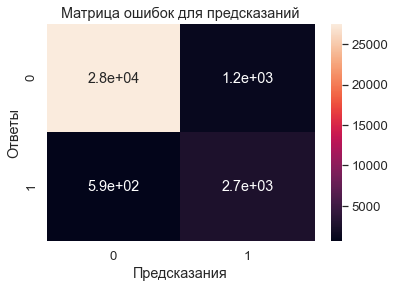

In [16]:
# Логистическая Регрессия
# Гиперпараметры были подобраны ранее
fit_test(LogisticRegression(random_state=42, 
                            class_weight='balanced',
                            C=10,
                            penalty='l2',
                            solver='newton-cg'))

F1 модели: 0.766


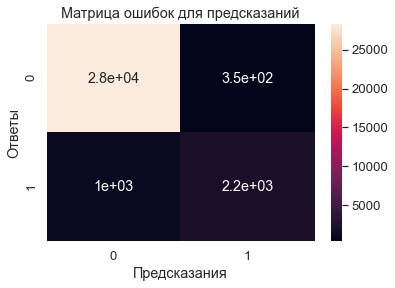

In [17]:
# LGBM классификатор
# Гиперпараметры были подобраны ранее
fit_test(LGBMClassifier(boosting_type='goss', 
                        n_estimators=250, 
                        learning_rate=0.2))

## Выводы

Была проведена работа по лемматизации и векторизации текста с дальнейшим подбором моделей для предсказания токсичности. Хорошую точность показала модель LGBM с F1-мерой 0.766, но ее обучение занимает некоторое время. Быстрее нее работает Логистическая Регрессия с F1 0.753. 

Выбирать модель стоит исходя из требований к скорости работы. Рискну предположить, что для подобного проекта высокая скорость обучения не требуется, потому стоит выбрать LGBM.